In [ ]:
%cd ../
%load_ext autoreload
%autoreload 2

In [2]:
import copy
import math
import os

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as T
from fsspec.core import url_to_fs
from hydra.utils import instantiate
from omegaconf import DictConfig, OmegaConf

from trainer.data.util import sparse_to_dense
from trainer.global_configs import DATASET_DIR, JOB_DIR
from trainer.helpers.layout_tokenizer import LayoutSequenceTokenizer
from trainer.helpers.sampling import SAMPLING_CONFIG_DICT
from trainer.helpers.task import filter_canvas, get_cond
from trainer.helpers.util import set_seed
from trainer.helpers.visualization import save_image
from trainer.hydra_configs import TestConfig
from trainer.models.common.util import load_model

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/usrs/shoiwai/miniconda3/envs/layout_corrector_test_env_2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def load_config(config_path: str):
    fs, _ = url_to_fs(config_path)
    if fs.exists(config_path):
        with fs.open(config_path, "rb") as file_obj:
            cfg = OmegaConf.load(file_obj)
        return cfg
    else:
        raise FileNotFoundError

def build_model(
    train_cfg: DictConfig, 
    device: str
) -> nn.Module:
    ## Define Models
    tokenizer = LayoutSequenceTokenizer(
        data_cfg=train_cfg.data, dataset_cfg=train_cfg.dataset
    )
    model = instantiate(train_cfg.model)(
        backbone_cfg=train_cfg.backbone, tokenizer=tokenizer
    ).to(device)
    return model

In [4]:
# configuration
DIFFUSION_JOB_DIR = "./download/pretrained_weights/rico25/layoutdm/0/"
CORRECTOR_JOB_DIR ="./download/pretrained_weights/rico25/layout_corrector/0/"

SIZE = (360, 240)
cond_type = "unconditional" # choices: unconditional, c, cwh
W_CANVAS = False
NUM_SAMPLES = 9

In [5]:
# build models

# layout generation model
diff_config_path = os.path.join(DIFFUSION_JOB_DIR, "config.yaml")
diff_train_cfg = load_config(diff_config_path)

diffusion = build_model(diff_train_cfg, device=device)
diffusion = load_model(
    model=diffusion,
    ckpt_dir=DIFFUSION_JOB_DIR,
    device=device,
    best_or_final="best"
)
diffusion.eval();


# layout-corrector
corr_config_path = os.path.join(CORRECTOR_JOB_DIR, "config.yaml")
corr_train_cfg = load_config(corr_config_path)

corrector = build_model(corr_train_cfg, device=device)
corrector = load_model(
    model=corrector,
    ckpt_dir=CORRECTOR_JOB_DIR,
    device=device,
    best_or_final="best"
)
corrector.eval();

In [6]:
tokenizer = diffusion.tokenizer
mask_id, pad_id = tokenizer.name_to_id("mask"), tokenizer.name_to_id("pad")
dataset = instantiate(corr_train_cfg.dataset)(split="test", transform=None)
save_kwargs = {
    "colors": dataset.colors, "names": dataset.labels,
    "canvas_size": SIZE, "use_grid": True,
}

## Unconditional Generation

In [7]:
cond_type = 'unconditional'

test_cfg = OmegaConf.structured(TestConfig)
test_cfg.cond = cond_type
default_sampling_cfg = corr_train_cfg.sampling
default_sampling_cfg = corrector.aggregate_sampling_settings(default_sampling_cfg, test_cfg)

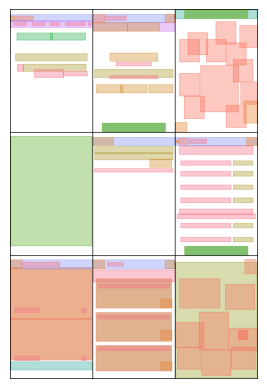

In [8]:
## Show Real Data
key_list = ['bbox', 'label', 'mask']
gt_batch = {k: [] for k in key_list}

for ind in range(NUM_SAMPLES):
    bbox, label, _, mask = sparse_to_dense(dataset[ind])
    gt_cond = tokenizer.encode(
        {"label": label, "mask": mask, "bbox": bbox}
    )
    if "bos" in tokenizer.special_tokens:
        gt = tokenizer.decode(gt_cond["seq"][:, 1:])
    else:
        gt = tokenizer.decode(gt_cond["seq"])
    if W_CANVAS:
        gt = filter_canvas(gt)  # remove canvas attributes before visualization
    
    for k in key_list:
        gt_batch[k].append(gt[k])
        
plt.axis("off")
plt.imshow(save_image(*(torch.stack(gt_batch[k]) for k in key_list), **save_kwargs))

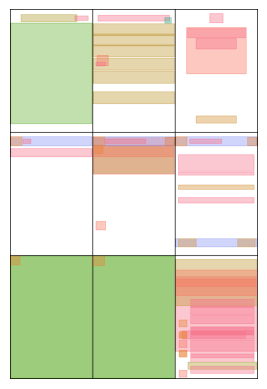

In [9]:
## Generate Layouts using Layout-Corrector
extra_sampling_args = dict(
    num_timesteps=100,
    corrector_start=-1,
    corrector_end=-1,
    corrector_t_list=[10, 20, 30],
    corrector_mask_mode="thresh",
    corrector_mask_thresh=0.7,
    use_gumbel_noise=True,
)
sampling_cfg = default_sampling_cfg.copy()
sampling_cfg.update(extra_sampling_args)

# set_seed(0) # uncomment this to ensure reproduceability
pred = diffusion.sample(batch_size=NUM_SAMPLES, cond=None, sampling_cfg=sampling_cfg, corrector=corrector)

plt.axis("off")
plt.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs))

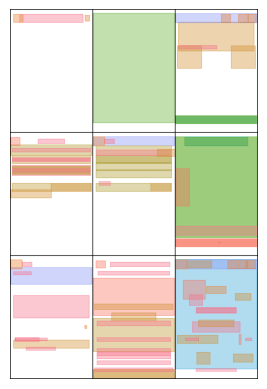

In [10]:
## Generate Layouts without Layout-Corrector

# set_seed(0) # uncomment this to ensure reproduceability
pred = diffusion.sample(batch_size=NUM_SAMPLES, cond=None, sampling_cfg=sampling_cfg, corrector=None)

plt.axis("off")
plt.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs))

## Conditional Generation

In [11]:
cond_type = 'c' # 'c' or 'cwh'
# 'c': class -> X, Y, W, H
# 'cwh': class + W, H -> X, Y

test_cfg = OmegaConf.structured(TestConfig)
test_cfg.cond = cond_type
default_sampling_cfg = corr_train_cfg.sampling
default_sampling_cfg = corrector.aggregate_sampling_settings(default_sampling_cfg, test_cfg)

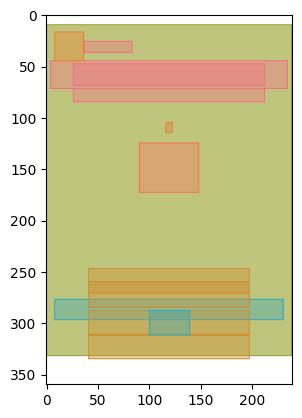

In [12]:
target_index = 100

cond = get_cond(
    batch=dataset[target_index],
    tokenizer=diffusion.tokenizer,
    cond_type=cond_type,
    model_type=type(diffusion).__name__,
)

bbox, label, _, mask = sparse_to_dense(dataset[target_index])
gt_cond = diffusion.tokenizer.encode(
    {"label": label, "mask": mask, "bbox": bbox}
)
if "bos" in tokenizer.special_tokens:
    gt = diffusion.tokenizer.decode(gt_cond["seq"][:, 1:])
else:
    gt = diffusion.tokenizer.decode(gt_cond["seq"])
if W_CANVAS:
    gt = filter_canvas(gt)  # remove canvas attributes before visualization
plt.imshow(save_image(gt["bbox"], gt["label"], gt["mask"], **save_kwargs))

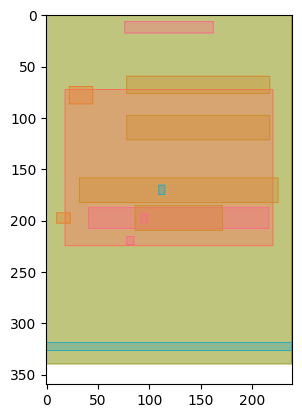

In [13]:
## Generate Layout using Layout-Corrector
extra_sampling_args = dict(
    num_timesteps=100,
    corrector_start=-1,
    corrector_end=-1,  
    corrector_t_list=[10, 20, 30],
    corrector_mask_mode="thresh",
    corrector_mask_thresh=0.7,
    use_gumbel_noise=True,
)
sampling_cfg = default_sampling_cfg.copy()
sampling_cfg.update(extra_sampling_args)

# set_seed(0) # uncomment this to ensure reproduceability
pred = diffusion.sample(batch_size=1, cond=cond, sampling_cfg=sampling_cfg, corrector=corrector)
plt.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs))

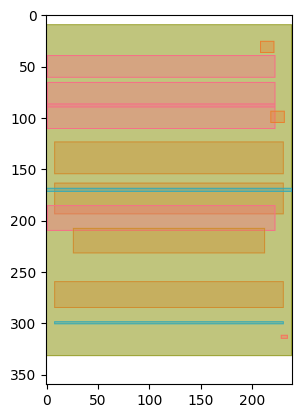

In [14]:
## Generate Layout without Layout-Corrector

# set_seed(0) # uncomment this to ensure reproduceability
pred = diffusion.sample(batch_size=1, cond=cond, sampling_cfg=sampling_cfg, corrector=None)
plt.imshow(save_image(pred["bbox"], pred["label"], pred["mask"], **save_kwargs))